In [24]:
from datasets import load_dataset
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset

import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer

[nltk_data] Downloading package stopwords to
[nltk_data]     /raid/home/namanmalpani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-11-18 19:58:40.119617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 19:58:40.139016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 19:58:40.144798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 19:58:40.163564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following i

In [19]:
# Load the dataset
dataset = load_dataset('QuyenAnhDE/data-for-text-summarization')

print(dataset)

# Extract text and summary from the training split
texts = dataset['train']['text']
summaries = dataset['train']['summary']

# Check the lengths of text and summary
print(f"Number of text entries: {len(texts)}")
print(f"Number of summary entries: {len(summaries)}")

# Create a DataFrame
data_df = pd.DataFrame({
    'text': texts,
    'summary': summaries
})


DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'chữ', 'bản tóm tắt'],
        num_rows: 6570
    })
})
Number of text entries: 6570
Number of summary entries: 6570


In [20]:
# Display the first few rows of the DataFrame
data_df.head()

,text,summary
0,"TOKYO, Jan 6 (Reuters) - ** Japan's rubber fut...","Japan's rubber futures slid on Thursday, rever..."
1,"WASHINGTON, Jan 5 (Reuters) - Federal Reserve ...",Federal Reserve officials said last month that...
2,Jan 24 (Reuters) - Gold was little changed on ...,\n\n* Gold is generally seen as an inflationar...
3,"JOHANNESBURG, Jan 5 (Reuters) - South Africa's...",South Africa's rand weakened in early trade on...
4,"TOKYO, Jan 21 (Reuters) - Japanese shares fell...","Japanese shares fell on Friday, with technolog..."


In [26]:
#Removing Duplicates
data_df.drop_duplicates(subset=['text'],inplace=True)

# Remove rows where either 'text' or 'summary' is None
data_df = data_df.dropna(subset=['text', 'summary'])

#Resetting the Index
data_df.reset_index(inplace=True, drop=True)

# Data Preprocessing

In [27]:
#Loading Stop Words
stop_words = stopwords.words('english')

#Defining the preprocess Function
def preprocess(text):
    
    #Converting Text to Lowercase
    text = text.lower()
    
    #Expanding Contractions
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    #Removing Stop Words
    tokens = [w for w in text.split() if not w in stop_words]
    
    #Additional Text Cleaning
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    
    #Returning the Cleaned Text
    return text


#Preprocessing the 'headlines' Column
data_df['text'] = data_df['text'].apply(preprocess)

#Preprocessing the 'text' Column
data_df['summary'] = data_df['summary'].apply(preprocess)

#Adding Start and End Tokens to 'headlines'
data_df['summary'] = data_df['summary'].apply(lambda x : '_START_ '+ x + ' _END_')

#Printing Processed Examples
for i in range(2):
    print('Summary:', data_df['summary'][i],'Text:', data_df['text'][i], sep='\n')
    print()

Summary:
_START_ japan rubber futures slid thursday reversing previous day gain anticipation faster policy tightening yous federal reserve dented risk appetite worries surge covid 19 cases weighed sentiment very tight job market unabated inflation might require federal reserve raise interest rates sooner expected begin reducing overall asset holdings second brake economy yous central bank policymakers said meeting last month growing concerns rapid spread omicron coronavirus variant also hurt market sentiment front month rubber contract singapore sicom exchange february delivery last traded 1752 yous cents per kg 03  _END_
Text:
tokyo jan 6 per tonne thursday very tight job market unabated inflation might require federal reserve raise interest rates sooner expected begin reducing overall asset holdings second brake economy yous central bank policymakers said meeting last month read growing concerns rapid spread omicron coronavirus variant also hurt market sentiment read front month rubb

In [32]:
#Calculating the Lengths of 'headlines'
text_length = [len(x.split()) for x in data_df.text]

#Calculating the Lengths of 'text'
summary_length = [len(x.split()) for x in data_df.summary]

print(f"Text Length : {max(text_length)}")
print(f"Summary Length : {max(summary_length)}" )


Text Length : 360
Summary Length : 251


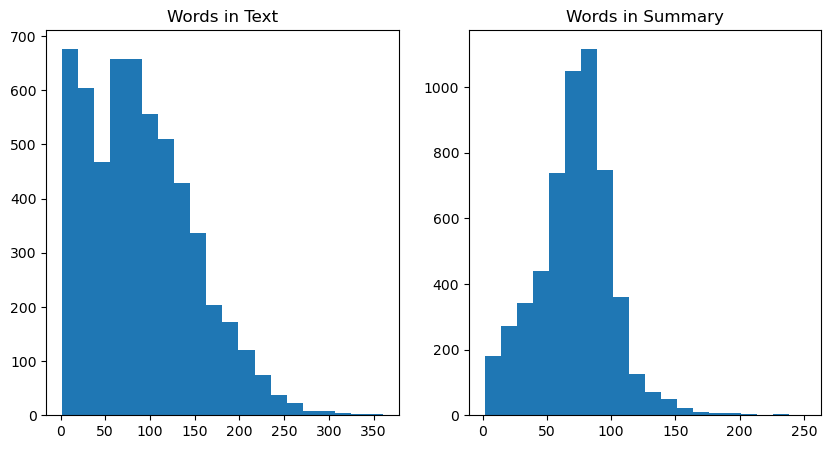

In [33]:
#Creating a Figure and Subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

#Plotting Histograms
ax1.hist(text_length, bins = 20)
ax2.hist(summary_length, bins = 20)

#Setting Titles for Subplots
ax1.title.set_text("Words in Text")
ax2.title.set_text("Words in Summary")

#Displaying the Plot
plt.show()

In [35]:
from sklearn.model_selection import train_test_split

#First Split: Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(data_df['text'], data_df['summary'], test_size = 0.2, random_state = 20)

#Second Split: Validation and Test Sets
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [36]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

In [38]:
#Creating and Fitting the Tokenizer
x_t = Tokenizer()
x_t.fit_on_texts(data_df['text'] +  data_df['summary'])

#Getting Vocabulary Size
x_vocab_size = len(x_t.word_index) + 1

#Encoding Texts into Sequences
encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

#Padding Sequences
padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')


In [39]:
#Creating and Fitting the Tokenizer
y_t = Tokenizer()
y_t.fit_on_texts(data_df['summary'])

#Getting Vocabulary Size
y_vocab_size = len(y_t.word_index) + 1

#Encoding Texts into Sequences
encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

#Padding Sequences
padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [40]:
padded_xtrain.shape

(4440, 360)